<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/main/Two_Assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Sample Paths

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [ ]:
def SimPaths(S0, kappa, theta, sigma, T, Ndt, Nsims):
    
    # time grid
    t = np.linspace(0, T, Ndt+1)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)

    # effective vol for large time steps
    #   sigma_eff = sigma *sqrt( (1-exp(-2*kappa*dt)) / (2*kappa) )
    #             ~ sigma *sqrt(  ( 1 - (1-2*kappa*dt + ..) ) /(2 *kappa) )
    #             ~ sigma *sqrt(  dt )
    sigma_eff = sigma * np.sqrt( (1-np.exp(-2*kappa*dt)) / (2*kappa))

    # store the sample paths
    X = np.zeros((Nsims, Ndt+1))
    Y = np.zeros((Nsims, Ndt+1))
    Z = np.zeros((Nsims, Ndt+1))

    X[:,0] = S0[0]
    Y[:,0] = S0[1]
    Z[:,0] = S0[2]


    for i in range(Ndt):

#         # Euler discretization of the SDE
#         #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
#         dW_x = sqrt_dt * np.random.randn(Nsims)
#         X[:,i+1] = X[:,i]  + kappa[0] * (theta[0] - X[:,i]) * dt + sigma[0] * dW_x

#         # Euler discretization of the SDE
#         #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
#         dW_y = sqrt_dt * np.random.randn(Nsims)
#         Y[:,i+1] = Y[:,i] + kappa[1] * (theta[1] - Y[:,i]) * dt + sigma[1] * dW_y

        # Exact solution to the SDE
        #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
        N_x =  np.random.randn(Nsims)
        X[:,i+1] = theta[0] + (X[:,i]-theta[0])*np.exp(-kappa[0]*dt) + sigma_eff[0] * N_x
        
        # Euler discretization of the SDE
        #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
        N_y = np.random.randn(Nsims)
        Y[:,i+1] = theta[1] + (Y[:,i]-theta[1])*np.exp(-kappa[1]*dt) + sigma_eff[1] * N_y

        # update Z according to no-arbitrage
        Z[:,i+1] = 1.0/(X[:,i+1]*Y[:,i+1])
        
    return t, X, Y, Z

In [ ]:
# model paramteres on hourly time scales
kappa = np.array([2, 2])
theta = np.array([1, 1.1])
sigma = np.array([1, 1])*1e-3

# initial values of the FX rates
X0 = 1.000
Y0 = 1.1 #1.0995
Z0 = 1.0/(X0*Y0)

T = 1 # in hours
Ndt = 6000 # in seconds

Nsims = 200 # number of sims

t, X, Y, Z = SimPaths([X0, Y0, Z0], kappa, theta, sigma, T, Ndt, Nsims)

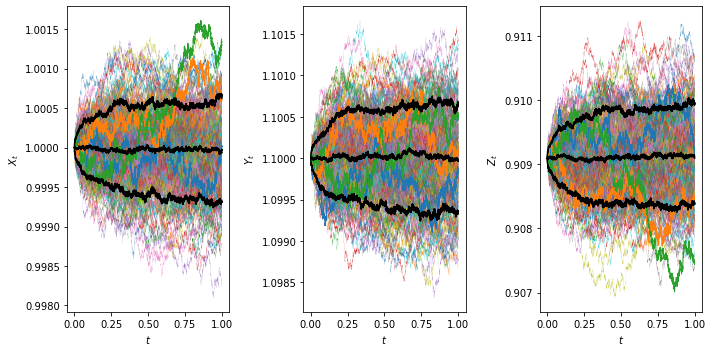

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, X.T, linewidth=0.1)
plt.plot(t, X[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(X,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$X_t$')

plt.subplot(1,3,2)
plt.plot(t, Y.T, linewidth=0.1)
plt.plot(t, Y[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Y,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Y_t$')

plt.subplot(1,3,3)
plt.plot(t, Z.T, linewidth=0.1)
plt.plot(t, Z[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Z,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Z_t$')

fig.tight_layout()

plt.show()

In [ ]:
print(t)

[0.00000000e+00 1.66666667e-04 3.33333333e-04 ... 9.99666667e-01
 9.99833333e-01 1.00000000e+00]


In [ ]:
train_test_split = 0.5
training_data = []
testing_data = []
time = [i for i in range(int(len(X)*len(X[0])*train_test_split))]
for i in range(len(X)):
  if i >= len(X)*train_test_split:
    for j in range(len(X[0])):
      testing_data.append(X[i][j])
  else:
    for j in range(len(X[0])):
      training_data.append(X[i][j])

In [ ]:
print(training_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import pandas as pd
data = {'Time': t, 
        'X': X[0],
        'Y' : Y[0],
        'Z': Z[0]}
  
# Convert the dictionary into DataFrame 
data = pd.DataFrame(data) 
print(data)

          Time         X         Y         Z
0     0.000000  1.000000  1.100000  0.909091
1     0.000167  1.000013  1.099995  0.909083
2     0.000333  1.000004  1.099980  0.909104
3     0.000500  0.999998  1.099985  0.909105
4     0.000667  1.000013  1.099959  0.909113
...        ...       ...       ...       ...
5996  0.999333  1.000013  1.099863  0.909192
5997  0.999500  1.000027  1.099862  0.909180
5998  0.999667  1.000009  1.099843  0.909212
5999  0.999833  1.000017  1.099843  0.909205
6000  1.000000  1.000005  1.099838  0.909220

[6001 rows x 4 columns]


In [ ]:
train_test_split = 0.5
train = data[:int(train_test_split*len(data))]
test = data[int(train_test_split*len(data)):]

In [ ]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act, trading_history):
        reward = 0
        
        # act = 
        #0: stay X stay Y
        #1: buy X buy Y
        #2: sell X sell Y
        #3: stay X buy Y
        #4: stay X sell Y
        #5: buy X sell Y
        #6: buy X stay Y
        #7: sell X buy Y
        #8: sell X stay Y
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['X'] + self.data.iloc[self.t, :]['Y'])
            trading_history.append("X")
            trading_history.append("Y")
        elif act == 2: # sell both
            if len(self.positions) == 0 or 'Y' not in trading_history or 'X' not in trading_history:
                reward = -1   #Penalize shortsellings
            else:
                profits = 0
                adjust = 0
                for p in range(len(self.positions)):
                    
                    #print("Index is: ", p-adjust, " position has length: ", len(self.positions))
                    if self.positions[p-adjust] >= 1.5:
                        profits += (self.data.iloc[self.t, :]['X']+self.data.iloc[self.t, :]['Y'] - self.positions[p-adjust])   #Differential Profit
                        del(self.positions[p-adjust])
                        adjust += 1
                        if 'X' in trading_history:
                          trading_history.reverse()
                          trading_history.remove('X')
                          trading_history.reverse()
                        
                        if 'Y' in trading_history:
                          trading_history.reverse()
                          trading_history.remove('Y')
                          trading_history.reverse()
                      
                reward += profits
                self.profits += profits
                #self.positions = []    #Not necessarily clear all positions
        elif act == 3: # stay X buy Y
            self.positions.append(self.data.iloc[self.t, :]['Y'])
            trading_history.append("Y")
        elif act == 4: # stay X sell Y
            if len(self.positions) == 0 or 'Y' not in trading_history:
                reward = -1   #Penalize shortsellings
            else:
                profits = 0
                adjust = 0 
                for p in range(len(self.positions)):
                       
                    #print("Index is: ", p-adjust, " position has length: ", len(self.positions))
                    if self.positions[p-adjust] < 1.5:
                      profits += (self.data.iloc[self.t, :]['Y'] - self.positions[p-adjust])   #Differential Profit
                      del(self.positions[p-adjust])
                      adjust += 1
                      if 'Y' in trading_history:
                        trading_history.reverse()
                        trading_history.remove('Y')
                        trading_history.reverse()
                      else:
                        reward = -1
                reward += profits
                self.profits += profits
        elif act == 5: # buy X sell Y
            if len(self.positions) == 0 or 'Y' not in trading_history:
                reward = -1   #Penalize shortsellings
            else:
                self.positions.append(self.data.iloc[self.t, :]['X'])   #Buy X
                trading_history.append("X")
                profits = 0
                adjust = 0
                for p in range(len(self.positions)):
                  
                  #print("Index is: ", p-adjust, " position has length: ", len(self.positions))
                  if self.positions[p-adjust] < 1.5:
                    profits += (self.data.iloc[self.t, :]['Y'] - self.positions[p-adjust])   #Differential Profit
                    del(self.positions[p-adjust])
                    adjust += 1
                    if 'Y' in trading_history:
                      trading_history.reverse()
                      trading_history.remove('Y')
                      trading_history.reverse()
                reward += profits
                self.profits += profits
        elif act == 6: # buy X stay Y
            self.positions.append(self.data.iloc[self.t, :]['X'])
            trading_history.append("X")
        elif act == 7: # sell X buy Y
            if len(self.positions) == 0 or 'X' not in trading_history:
                reward = -1   #Penalize shortsellings
            else:
                self.positions.append(self.data.iloc[self.t, :]['Y'])   #Buy Y
                trading_history.append("Y")
                profits = 0
                adjust = 0
                for p in range(len(self.positions)):
                  
                  #print("Index is: ", p-adjust, " position has length: ", len(self.positions))
                  if self.positions[p-adjust] < 1.5:
                    profits += (self.data.iloc[self.t, :]['X'] - self.positions[p-adjust])   #Differential Profit
                    del(self.positions[p-adjust])
                    adjust += 1
                    if 'X' in trading_history:
                      trading_history.reverse()
                      trading_history.remove('X')
                      trading_history.reverse()
                reward += profits
                self.profits += profits
        elif act == 8: # sell X stay Y
            if len(self.positions) == 0 or 'X' not in trading_history:
                reward = -1   #Penalize shortsellings
            else:
                profits = 0
                adjust = 0
                for p in range(len(self.positions)):
                  
                 # print("Index is: ", p-adjust, " position has length: ", len(self.positions))
                  if self.positions[p-adjust] < 1.5:
                    profits += (self.data.iloc[self.t, :]['X'] - self.positions[p-adjust])   #Differential Profit
                    del(self.positions[p-adjust])
                    adjust += 1
                    if 'X' in trading_history:
                      trading_history.reverse()
                      trading_history.remove('X')
                      trading_history.reverse()
                    else:
                      reward = -1
                reward += profits
                self.profits += profits
   
        
        # set next time
        self.t += 1
        updated_trading_history = trading_history
        self.position_value = 0   #Store the unrealized gain
        for p in range(len(self.positions)):
            if 'X' in trading_history and 'Y' in trading_history:
              self.position_value += (self.data.iloc[self.t, :]['X']+self.data.iloc[self.t, :]['Y'] - self.positions[p])
            elif 'X' in trading_history:
              self.position_value += (self.data.iloc[self.t, :]['X']- self.positions[p])
            else:
              self.position_value += (self.data.iloc[self.t, :]['Y']- self.positions[p])
        #print(self.position_value)
        self.history.pop(0)
        #print(self.data)
        self.history.append(self.data.iloc[self.t, :]['X'] - self.data.iloc[(self.t-1), :]['X'] +self.data.iloc[self.t, :]['Y']- self.data.iloc[(self.t-1), :]['Y'])   #Price Movement of X
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done, updated_trading_history # obs, reward, done

In [ ]:
env = Environment1(train)

In [ ]:
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [ ]:
hidden_size=100
input_size=env.history_t+1
output_size=9
USE_CUDA = False
LR = 0.001

In [ ]:
Q = Q_Network(input_size, hidden_size, output_size)

In [ ]:
Q_ast = copy.deepcopy(Q)


In [ ]:
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

In [ ]:
epoch_num = 100
step_max = len(env.data)-1
memory_size = 200
batch_size = 200
gamma = 0.97

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 400
train_freq = 2
update_q_freq = 2
gamma = 0.97
show_log_freq = 5


In [ ]:
#start = time.time()
for epoch in range(epoch_num):

    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(9)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done, trading_history = env.step(pact,trading_history)
        #print("action is: ", pact, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

Streaming output truncated to the last 5000 lines.
70	0.0999999999999992	207731	-18903844.0	3193438627211164.5
70	0.0999999999999992	207732	-18903882.4	3193438627212340.0
70	0.0999999999999992	207733	-18903920.8	3193438627213517.0
70	0.0999999999999992	207734	-18903959.2	3193438627214693.5
70	0.0999999999999992	207735	-18903997.6	3193438627215871.0
70	0.0999999999999992	207736	-18904036.0	3193438627217049.0
70	0.0999999999999992	207737	-18904074.2	3193438627218227.5
70	0.0999999999999992	207738	-18904112.4	3193438627219406.5
70	0.0999999999999992	207739	-18904150.6	3193438627220586.0
70	0.0999999999999992	207740	-18904188.8	3193438627221765.5
70	0.0999999999999992	207741	-18904227.0	3193438627222946.5
70	0.0999999999999992	207742	-18904265.2	3193438627224127.0
70	0.0999999999999992	207743	-18904303.4	3193438627225309.0
70	0.0999999999999992	207744	-18904341.6	3193438627226490.5
70	0.0999999999999992	207745	-18904379.8	3193438627227673.0
70	0.0999999999999992	207746	-18904418.0	31934386

3999


Text(0, 0.5, 'Losses')

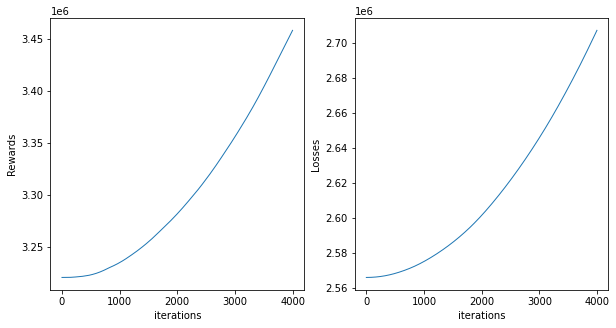

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(iterations, log_rewards, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Rewards')
plt.subplot(1,2,2)
plt.plot(iterations, log_losses, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Losses')

In [ ]:
print(len(log_rewards))
incremental_reward = []
for i in range(len(log_rewards)):
  if i>=1:
    incremental_reward.append((log_rewards[i]-log_rewards[i-1])/memory_size)


3999


Text(0, 0.5, 'incremental_reward')

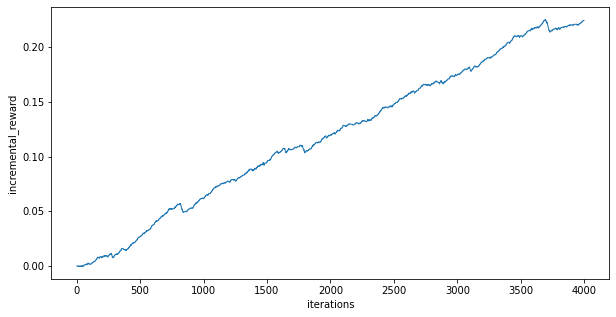

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(iterations[:-1], incremental_reward, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('incremental_reward')

In [ ]:
test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
    #print(pact.numpy())        
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits

In [ ]:
print(test_profits)

-0.0016187753129859317


In [ ]:
#Try another sample path
data = {'Time': t, 
        'X': X[1], 
        'Y': Y[1],
        'Z': Z[1]} 
  
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data) 
test = df[:]

In [ ]:
class Environment2:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1   #Penalize shortsellings
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)   #Differential Profit
                reward += profits
                self.profits += profits
                self.positions = []       
        
        # set next time
        self.t += 1
        
        self.position_value = 0   #Store the unrealized gain
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        #print(self.position_value)
        self.history.pop(0)
        #print(self.data)
        self.history.append(self.data.iloc[self.t, :]['X'] - self.data.iloc[(self.t-1), :]['X'])   #Price Movement of X
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [ ]:
test_env = Environment2(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
    #print(pact.numpy())        
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits
print(test_profits)

3.450363834855974e-05


In [ ]:
#Try all sample path
samplepath_number = []
test_profits = []
for i in range(len(X)):
  data = {'Time': t, 
        'X': X[i]}
  # Convert the dictionary into DataFrame 
  df = pd.DataFrame(data) 
  test = df[:]
  test_env = Environment2(test)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []

  for _ in range(len(test_env.data)-1):
      
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      obs, reward, done = test_env.step(pact.numpy())
      test_rewards.append(reward)

      pobs = obs
          
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)




(array([ 20., 122.,  58.]),
 array([-0.06446519, -0.02604935,  0.01236649,  0.05078233]),
 <a list of 3 Patch objects>)

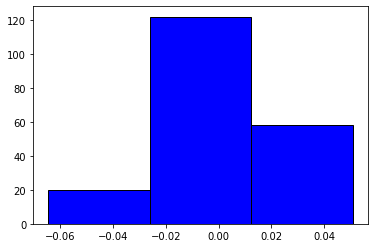

In [ ]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 10)